<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/VGG16_FullFrozen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [ ]:
# I set up a transformation pipeline to resize the image to 224x224, convert it to a tensor, and normalize using ImageNet mean and std

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Loading the Flowers102 dataset for training, validation, and testing, applying the defined transformations and downloading

train_data = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)

100%|██████████| 345M/345M [00:13<00:00, 25.2MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1.23MB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 36.3MB/s]


In [ ]:
# Creating data loaders for training, validation, and testing with a batch size of 32, shuffling only the training data.

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
# Loading the pretrained VGG16 model and freezing all its parameters to prevent updates during training,
# ensuring only the custom classifier layers will be trained, leveraging the pretrained features.

model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 158MB/s]


In [ ]:
# Then, I replace the final layer in the VGG16 classifier with a new linear layer to output 102 classes for the Flowers102 dataset.
# I enable training only for the parameters in this new layer, allowing it to learn to classify the dataset while other layers remain frozen.

model.classifier[6] = nn.Linear(in_features=4096, out_features=102)
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [ ]:
# Setting the device to GPU if available; otherwise, default to CPU, and then transfer the model to the selected device for optimized processing.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Defining the loss function as cross-entropy for multi-class classification and setting up the Adam optimizer,
# applying it only to trainable parameters in the model with a learning rate of 0.001.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), correct / total

In [ ]:
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), correct / total

In [ ]:
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
num_epochs = 100
best_val_acc = 0.0
patience = 5
counter = 0
train_loss_history=[]
train_acc_history=[]
val_loss_history=[]
val_acc_history=[]

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'Best_Vgg16_FullFrozen.pth')
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy for {patience} consecutive epochs.")
        break

Epoch [1/100], Train Loss: 3.8883, Train Accuracy: 0.1863, Validation Loss: 2.2391, Validation Accuracy: 0.5784
Epoch [2/100], Train Loss: 1.3680, Train Accuracy: 0.7284, Validation Loss: 1.5052, Validation Accuracy: 0.6853
Epoch [3/100], Train Loss: 0.7842, Train Accuracy: 0.8627, Validation Loss: 1.2732, Validation Accuracy: 0.7167
Epoch [4/100], Train Loss: 0.5445, Train Accuracy: 0.9049, Validation Loss: 1.1798, Validation Accuracy: 0.7137
Epoch [5/100], Train Loss: 0.4134, Train Accuracy: 0.9343, Validation Loss: 1.0959, Validation Accuracy: 0.7314
Epoch [6/100], Train Loss: 0.3019, Train Accuracy: 0.9569, Validation Loss: 1.0577, Validation Accuracy: 0.7402
Epoch [7/100], Train Loss: 0.2473, Train Accuracy: 0.9716, Validation Loss: 1.0346, Validation Accuracy: 0.7441
Epoch [8/100], Train Loss: 0.2067, Train Accuracy: 0.9745, Validation Loss: 1.0073, Validation Accuracy: 0.7588
Epoch [9/100], Train Loss: 0.1790, Train Accuracy: 0.9755, Validation Loss: 0.9965, Validation Accuracy:

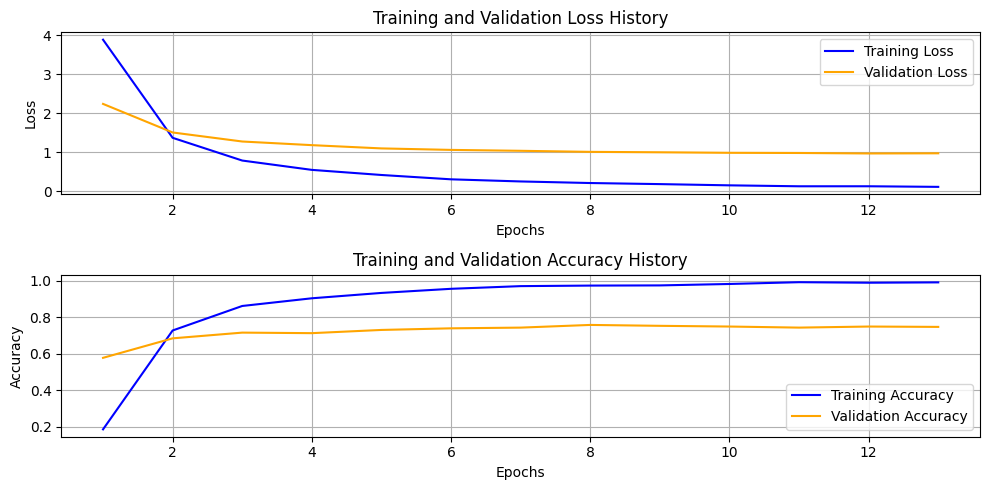

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(torch.load('Best_Vgg16_FullFrozen.pth'))
test_acc = test_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

<ipython-input-14-7b741d4f7c0f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Best_Vgg16_FullFrozen.pth'))


Test Accuracy: 0.7222
